# Toy Models of Superposition: Visualization & Analysis

This notebook explores different toy models that may or may not exhibit superposition. Each model is formed by a simple MLP layer, containing 50 neurons, and receives 100 features as input. The model will perform $y = ReLU(x) + x$. 
The models assessed are: 
- $y = ReLU(x) + x$ model with identity embeddings, trained at low sparsity.
- $y = ReLU(x) + x$ Model with identity embeddings, trained at high sparsity.
- $y = ReLU(x) + x$ Model with random embeddings, trained at low sparsity.
- $y = ReLU(x) + x$ Model with random embeddings, trained at high sparsity.
- Giorgi's model
- Lucius handcoded model

Each model is trained at a fixed sparsity level, and then several analysis are performed to investigate its behaviour:
- Performance testing across various sparsity levels.
- Feature representation through input-output response across features.
- Distributions of feature weights per neuron and neuron weights per features.

To add later: 
- Phase diagram with axis training sparsity vs input sparsity, color = adjusted loss or polysemanticity


In [1]:
# Set up notebook

"""Import necessary packages"""

%load_ext autoreload
%autoreload 2

import os
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import torch as t
import matplotlib.pyplot as plt

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
import seaborn as sns
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis.plot import plot_weight_bars, plot_input_output_response
from toy_cis.util import threshold_matrix, in_out_response

"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 16})

"""Set torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# device = t.device("cpu")  # small toy models have lower loss and are faster via cpu
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA A40'


In [2]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, x + t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    n_steps: int,
    lr: float,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []
    
    optimizer = t.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    
    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        
        # Update the learning rate
        current_lr = lr * np.cos(0.5 * np.pi * step / (n_steps - 1))
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_lr
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

## 1. *ReLU_PlusX with Identity Embedding (= no embedding)*

Target: 
$$
y = x + ReLU(x)
$$

Linear map: 

$$
h = ReLU(W_1x)$$
$$
y' = W_2h + x
$$

Input (sparsity=0.99, so feature_probability=0.01 for each feature on each example):

$$
x = \text{rand}(-1, 1)
$$

Loss (mse):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
$$

In [3]:
"""Initialize model."""

layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_noEmbed_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=False,
)

In [4]:
"""Train model at low sparsity (S = 0.5)"""

reluPlusX_res_noEmbed_cis = Cis(reluPlusX_res_noEmbed_cfg, device=device).to(device)

batch_sz = 1024
feat_sparsity = 0.5
feat_importance = 1
lr = 3e-3
n_steps = 10000
logging_freq = n_steps // 10

losses = train(
        reluPlusX_res_noEmbed_cis,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        n_steps,
        lr, 
        logging_freq
)
display(losses)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.0834202915430069,
 0.03430268540978432,
 0.0339844636619091,
 0.03397355601191521,
 0.03382697328925133,
 0.03430303931236267,
 0.034567199647426605,
 0.034302204847335815,
 0.03345697745680809,
 0.03341994807124138,
 0.03410905599594116]

In [5]:
"""Get loss at inference over varying sparsity levels."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1
logging_freq = n_steps // 10

loss_data = []  # will store mean loss data

pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 10000
loss_data = []
for s in pbar:
    
    with t.no_grad():
        # generate examples of inputs
        x, y_true = gen_batch(reluPlusX_res_noEmbed_cis, n_examples, s)
        
        # compute mean loss
        y = reluPlusX_res_noEmbed_cis.forward(x)
        active_weight, inactive_weight = 10, 1
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        loss = weights * (y - y_true) ** 2
        
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
            loss_data.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})


Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

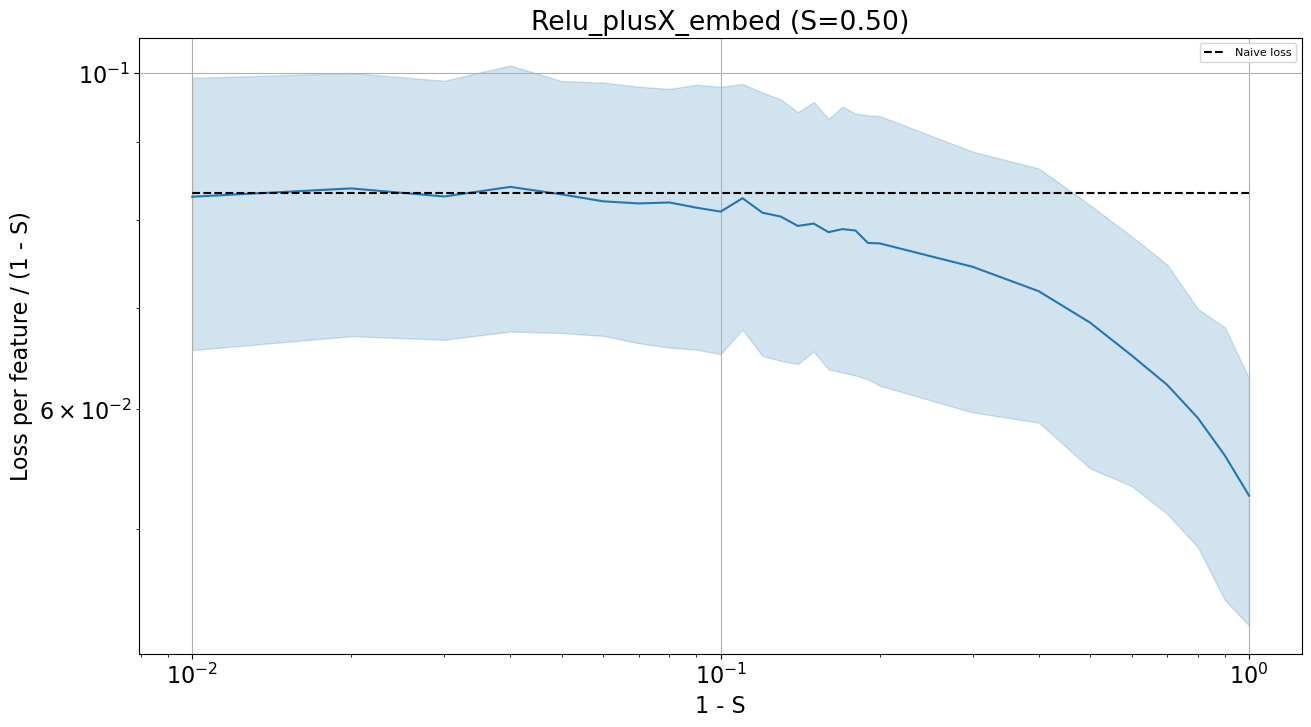

In [6]:
"""Plot performance across different input sparsities"""

# convert loss data to DataFrame, convert sparsity to probability and adjust loss
df_loss = pd.DataFrame(loss_data) 
df_loss["1-S"] = 1 - df_loss["sparsity"]
df_loss["loss/1-S"] = df_loss["loss_per_feature"] / (1 - df_loss["sparsity"])

naive_loss = 0.5 * (1 - sparsities) / 6 # compute naive loss (monosemantic solution)
norm_loss = naive_loss.ravel() / (1 - sparsities)

# plot performance vs input sparsity
fig = plt.figure(figsize=(15, 8))
sns.lineplot(data = df_loss, x = "1-S", y = "loss/1-S")

# add naive loss line
plt.plot(1- sparsities, norm_loss, linestyle="dashed", color="black", label=r"Naive loss") 

# add labels and scale
plt.xlabel('1 - S')
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend(loc = "best", fontsize = 8)
plt.ylabel('Loss per feature / (1 - S)')
plt.title('Relu_plusX_embed (S=0.50)')

# save figure and show
plt.savefig("/workspace/reluPlusX_NoEmbed_S=050_performance.png", dpi=200)
plt.show()

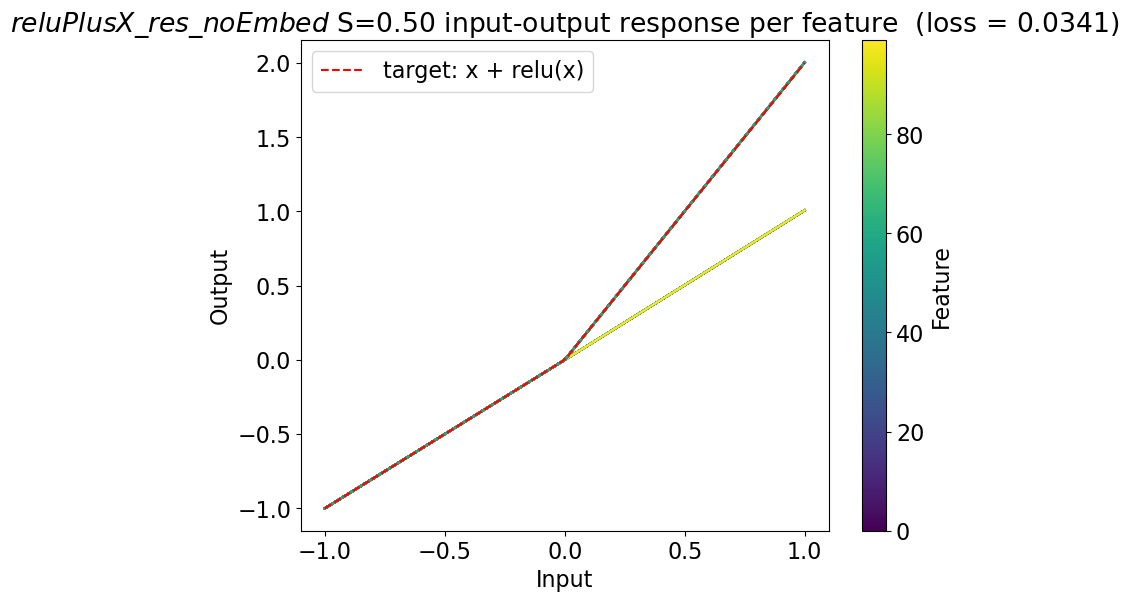

In [7]:
"""Plot feature representation (input-output response)"""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(reluPlusX_res_noEmbed_cis, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(
    asnumpy(vals), asnumpy(vals + t.relu(vals)), color="red", linestyle="--", label="target: x + relu(x)"
)
ax.set_title(
    r"$\mathit{reluPlusX\_res\_noEmbed}$ S=0.50 " 
    + f"input-output response per feature  (loss = {losses[-1]:.4f})"
)
ax.legend()

W.shape=torch.Size([50, 100])


Text(0.5, 1.0, 'ReLU_PlusX_NoEmbed S = 0.50 feature weights per neuron')

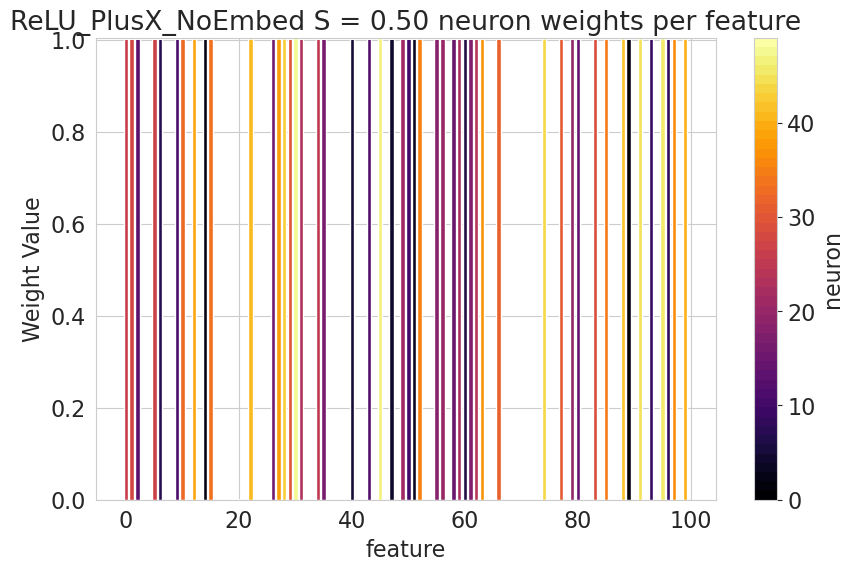

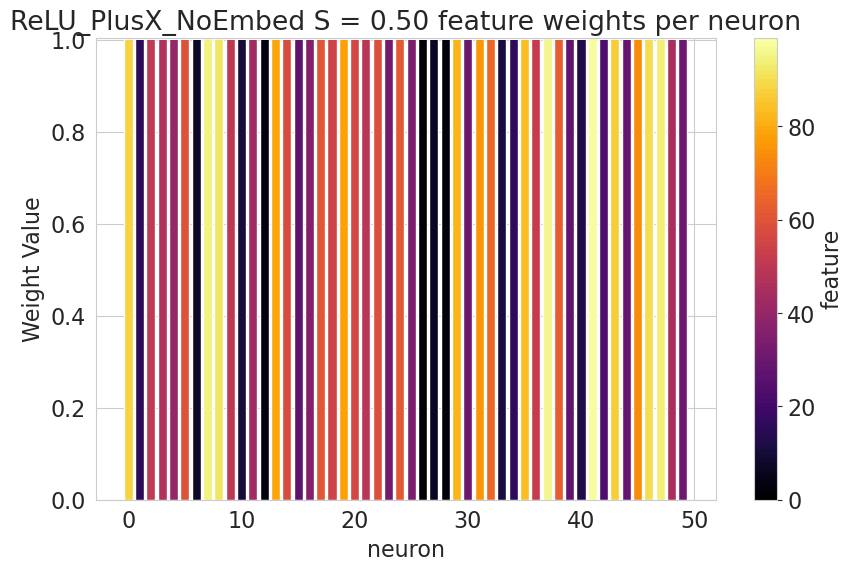

In [8]:
"""Plot weights for neurons per feature, and for features per neuron."""

W = einsum(reluPlusX_res_noEmbed_cis.W1, reluPlusX_res_noEmbed_cis.W2, "inst neuron feature, inst feature neuron-> neuron feature")
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature")
fig.get_axes()[0].set_title("ReLU_PlusX_NoEmbed S = 0.50 neuron weights per feature")

fig = plot_weight_bars(W.T, xax="neuron")
fig.get_axes()[0].set_title("ReLU_PlusX_NoEmbed S = 0.50 feature weights per neuron")

In [9]:
"""Train model at high sparsity (S = 0.99)"""

reluPlusX_res_noEmbed_cis = Cis(reluPlusX_res_noEmbed_cfg, device=device).to(device)

batch_sz = 1024
feat_sparsity = 0.99
feat_importance = 1
lr = 3e-3
n_steps = 100000
logging_freq = n_steps // 10

losses = train(
        reluPlusX_res_noEmbed_cis,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        n_steps,
        lr, 
        logging_freq
)
display(losses)

Training:   0%|          | 0/100000 [00:00<?, ?it/s]

[0.0016756369732320309,
 0.0008564596646465361,
 0.0009083780460059643,
 0.000742344418540597,
 0.0009031709632836282,
 0.0007426633383147418,
 0.0006994557334110141,
 0.0008127425680868328,
 0.0008306973031722009,
 0.0007767356582917273,
 0.0008205667836591601]

In [10]:
"""Get loss at inference over varying sparsity levels."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1
logging_freq = n_steps // 10

loss_data = []  # will store loss data

pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 10000
loss_data = []
for s in pbar:
    
    with t.no_grad():
        # generate examples of inputs
        x, y_true = gen_batch(reluPlusX_res_noEmbed_cis, n_examples, s)
        
        # compute mean loss
        y = reluPlusX_res_noEmbed_cis.forward(x)
        active_weight, inactive_weight = 10, 1
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        loss = weights * (y - y_true) ** 2
        
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
            loss_data.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

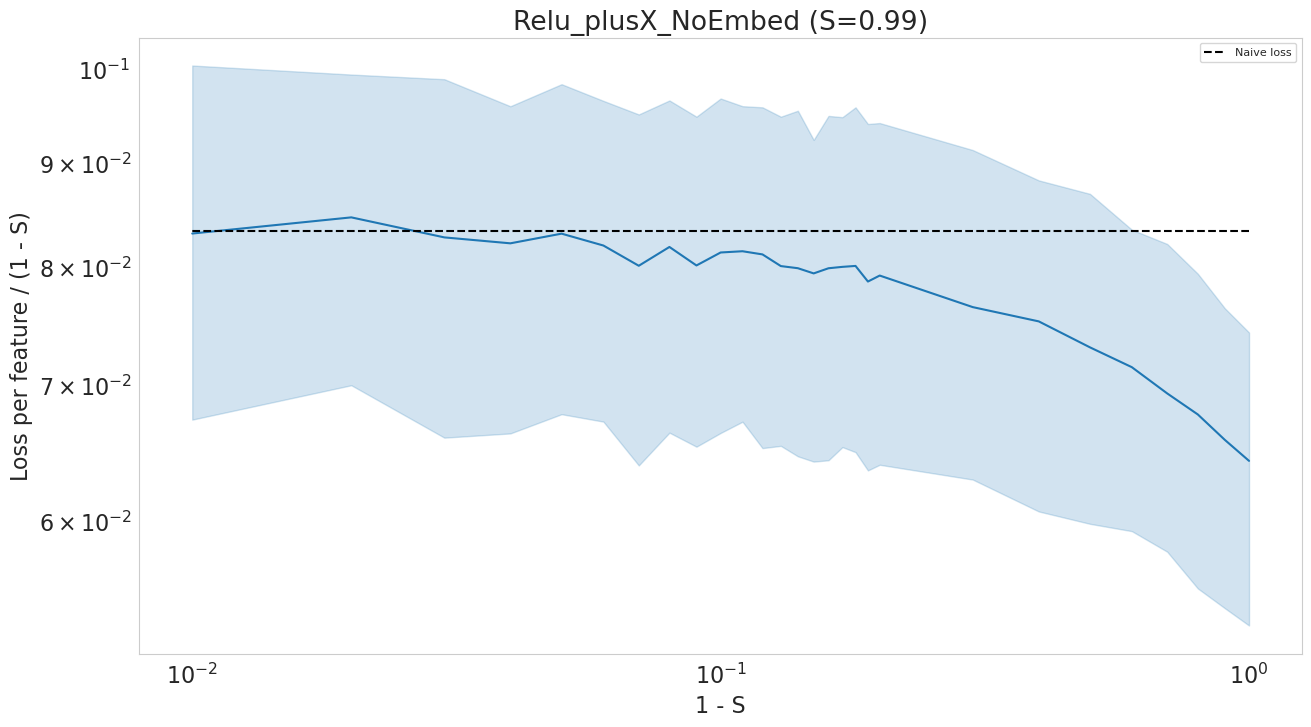

In [11]:
"""Plot performance across different input sparsities"""

# convert loss data to DataFrame, convert sparsity to probability and adjust loss
df_loss = pd.DataFrame(loss_data) 
df_loss["1-S"] = 1 - df_loss["sparsity"]
df_loss["loss/1-S"] = df_loss["loss_per_feature"] / (1 - df_loss["sparsity"])

naive_loss = 0.5 * (1 - sparsities) / 6 # compute naive loss (monosemantic solution)
norm_loss = naive_loss.ravel() / (1 - sparsities)

# plot performance vs input sparsity
fig = plt.figure(figsize=(15, 8))
sns.lineplot(data = df_loss, x = "1-S", y = "loss/1-S")

# add naive loss line
plt.plot(1- sparsities, norm_loss, linestyle="dashed", color="black", label=r"Naive loss") 

# add labels and scale
plt.xlabel('1 - S')
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend(loc = "best", fontsize = 8)
plt.ylabel('Loss per feature / (1 - S)')
plt.title('Relu_plusX_NoEmbed (S=0.99)')

# save figure and show
plt.savefig("/workspace/reluPlusX_NoEmbed_S=099_performance.png", dpi=200)
plt.show()

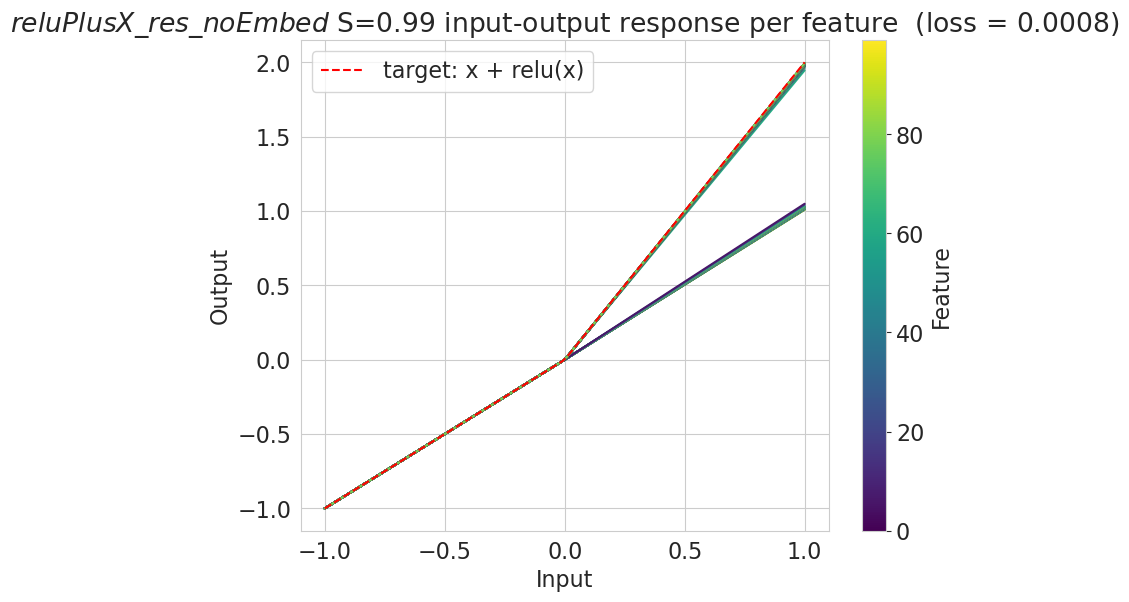

In [12]:
"""Plot feature representation (input-output response)"""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(reluPlusX_res_noEmbed_cis, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(
    asnumpy(vals), asnumpy(vals + t.relu(vals)), color="red", linestyle="--", label="target: x + relu(x)"
)
ax.set_title(
    r"$\mathit{reluPlusX\_res\_noEmbed}$ S=0.99 " 
    + f"input-output response per feature  (loss = {losses[-1]:.4f})"
)
ax.legend()

W.shape=torch.Size([50, 100])


Text(0.5, 1.0, 'ReLU_PlusX_NoEmbed S = 0.99 feature weights per neuron')

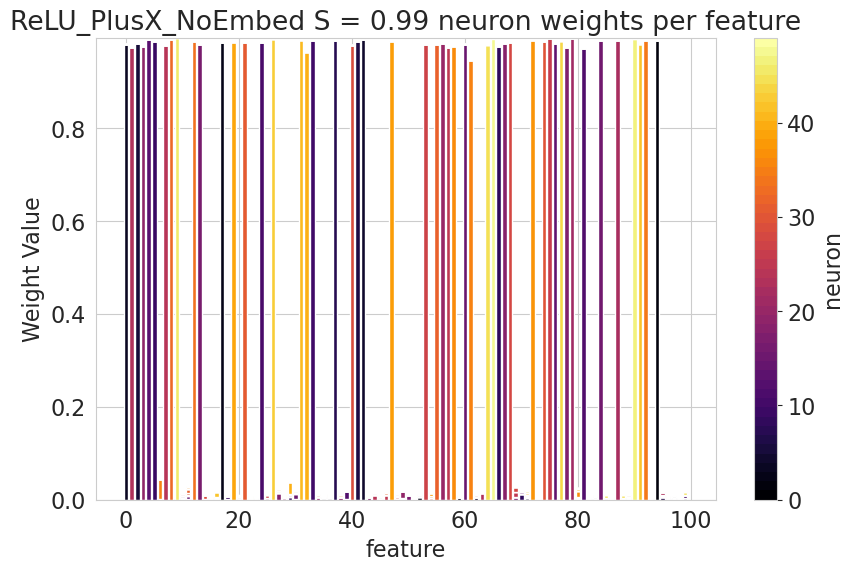

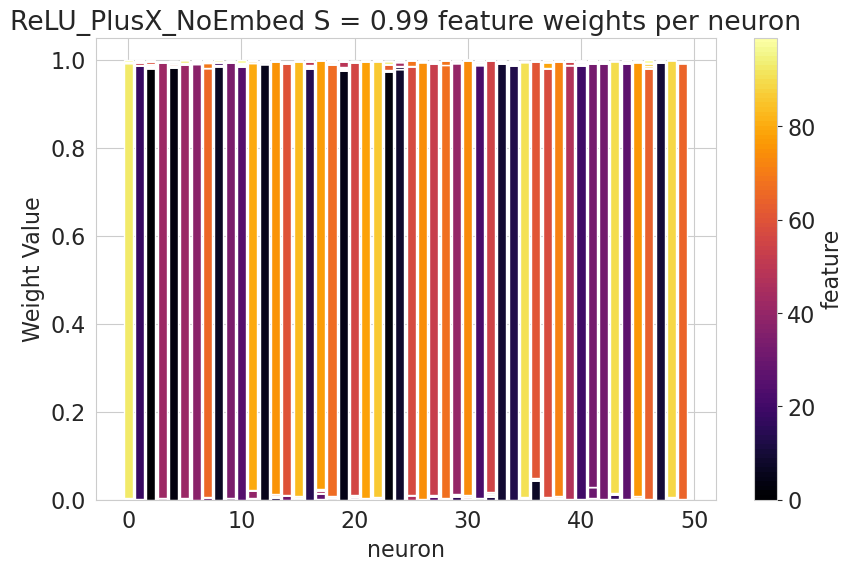

In [13]:
"""Plot weights for neurons per feature, and for features per neuron."""

W = einsum(reluPlusX_res_noEmbed_cis.W1, reluPlusX_res_noEmbed_cis.W2, "inst neuron feature, inst feature neuron-> neuron feature")
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature")
fig.get_axes()[0].set_title("ReLU_PlusX_NoEmbed S = 0.99 neuron weights per feature")

fig = plot_weight_bars(W.T, xax="neuron")
fig.get_axes()[0].set_title("ReLU_PlusX_NoEmbed S = 0.99 feature weights per neuron")

## 2. *ReLU_PlusX with Random Embedding*

Target: 
$$
y = x + ReLU(x)
$$

Linear map: 

$$
e = W_e x$$
$$h = ReLU(W_1 e)$$
$$u = W_2 h + x$$
$$y' = W_u u
$$

Input (sparsity=0.99, so feature_probability=0.01 for each feature on each example):

$$
x = \text{rand}(-1, 1) \\
$$

Loss (mse):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
$$

In [14]:
"""Initialize model."""

layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_embed_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000
)

In [15]:
"""Train model at low sparsity (S=0.50)"""

reluPlusX_res_embed_cis = Cis(reluPlusX_res_embed_cfg, device=device)

batch_sz = 2048
feat_sparsity = 0.50
feat_importance = 1
lr = 3e-3
n_steps = 10000
logging_freq = n_steps // 10


losses = train(
        reluPlusX_res_embed_cis,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        n_steps,
        lr, 
        logging_freq
)
display(losses)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.09909725189208984,
 0.036485448479652405,
 0.03660077974200249,
 0.03628188371658325,
 0.036202896386384964,
 0.036259911954402924,
 0.03598158806562424,
 0.036038126796483994,
 0.036152955144643784,
 0.03571201115846634,
 0.03593045100569725]

In [16]:
"""Get loss at inference over varying sparsity levels."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1
logging_freq = n_steps // 10

loss_data = []  # will store loss data

pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 10000
loss_data = []
for s in pbar:
    
    with t.no_grad():
        # generate examples of inputs
        x, y_true = gen_batch(reluPlusX_res_embed_cis, n_examples, s)
        
        # compute mean loss
        y = reluPlusX_res_embed_cis.forward(x)
        active_weight, inactive_weight = 10, 1
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        loss = weights * (y - y_true) ** 2
        
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
            loss_data.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

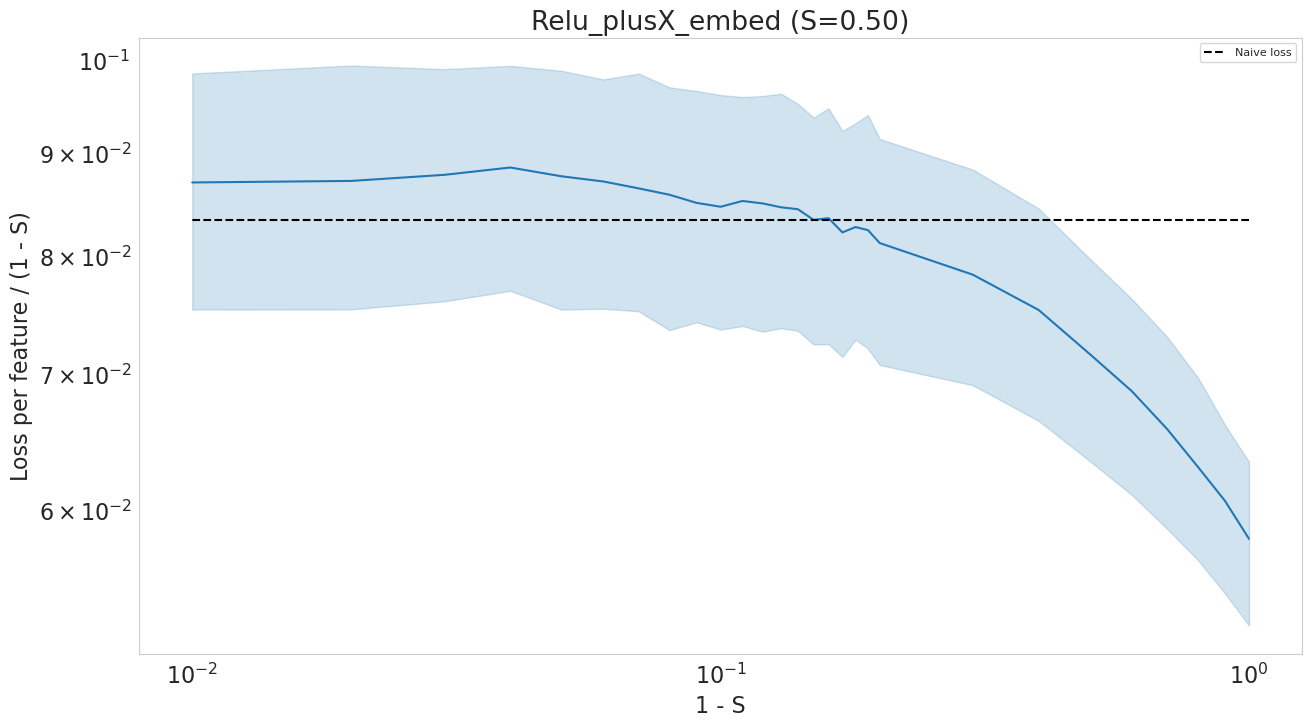

In [17]:
"""Plot performance across different input sparsities"""

# convert loss data to DataFrame, convert sparsity to probability and adjust loss
df_loss = pd.DataFrame(loss_data) 
df_loss["1-S"] = 1 - df_loss["sparsity"]
df_loss["loss/1-S"] = df_loss["loss_per_feature"] / (1 - df_loss["sparsity"])

naive_loss = 0.5 * (1 - sparsities) / 6 # compute naive loss (monosemantic solution)
norm_loss = naive_loss.ravel() / (1 - sparsities)

# plot performance vs input sparsity
fig = plt.figure(figsize=(15, 8))
sns.lineplot(data = df_loss, x = "1-S", y = "loss/1-S")

# add naive loss line
plt.plot(1- sparsities, norm_loss, linestyle="dashed", color="black", label=r"Naive loss") 

# add labels and scale
plt.xlabel('1 - S')
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend(loc = "best", fontsize = 8)
plt.ylabel('Loss per feature / (1 - S)')
plt.title('Relu_plusX_embed (S=0.50)')

# save figure and show
plt.savefig("/workspace/reluPlusX_Embed_S=050_performance.png", dpi=200)
plt.show()

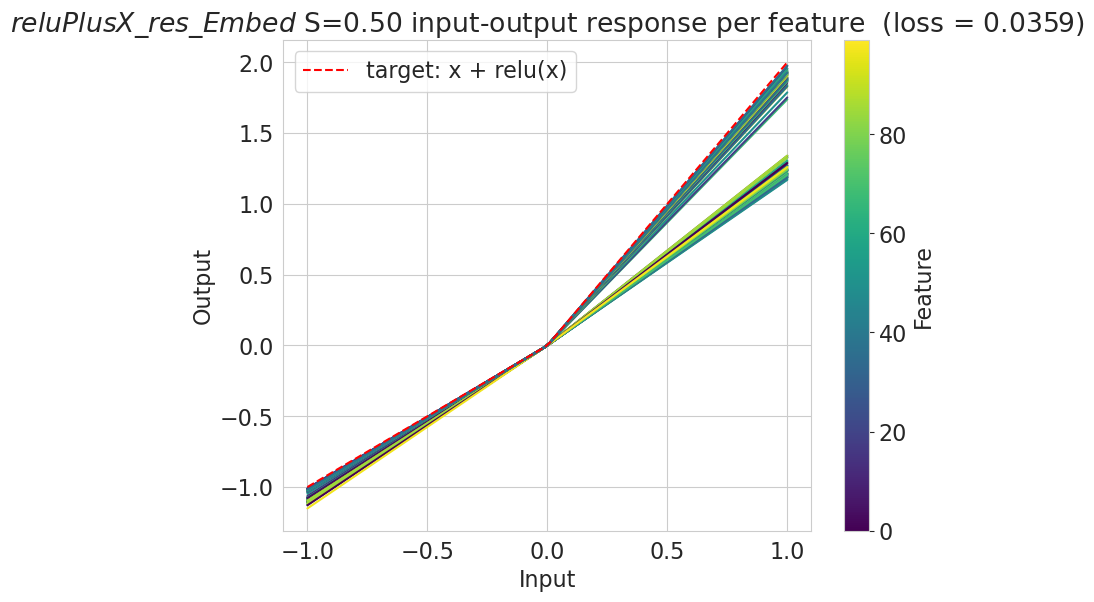

In [18]:
"""Plot feature representation (input-output response)"""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(reluPlusX_res_embed_cis, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(
    asnumpy(vals), asnumpy(vals + t.relu(vals)), color="red", linestyle="--", label="target: x + relu(x)"
)
ax.set_title(
    r"$\mathit{reluPlusX\_res\_Embed}$ S=0.50 " 
    + f"input-output response per feature  (loss = {losses[-1]:.4f})"
)
ax.legend()

W.shape=torch.Size([50, 100])


Text(0.5, 1.0, 'ReLU_PlusX_NoEmbed S = 0.50 feature weights per neuron')

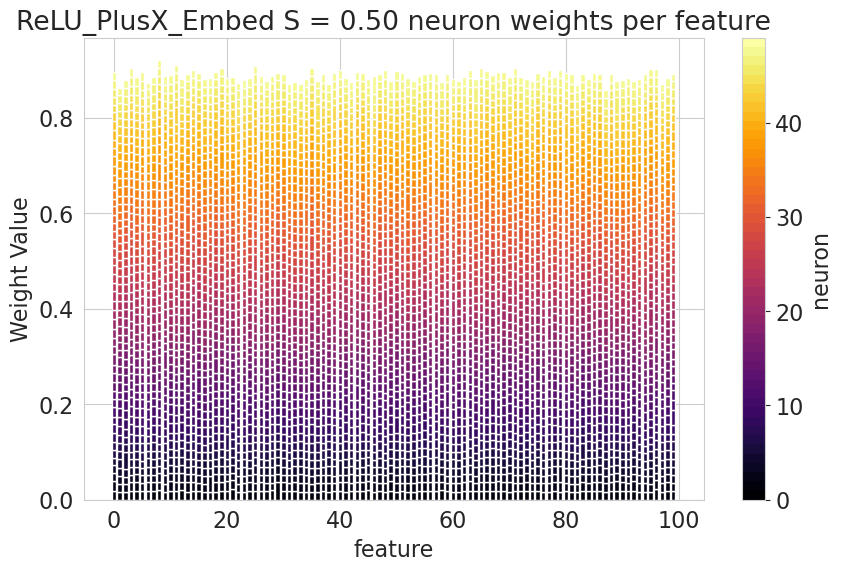

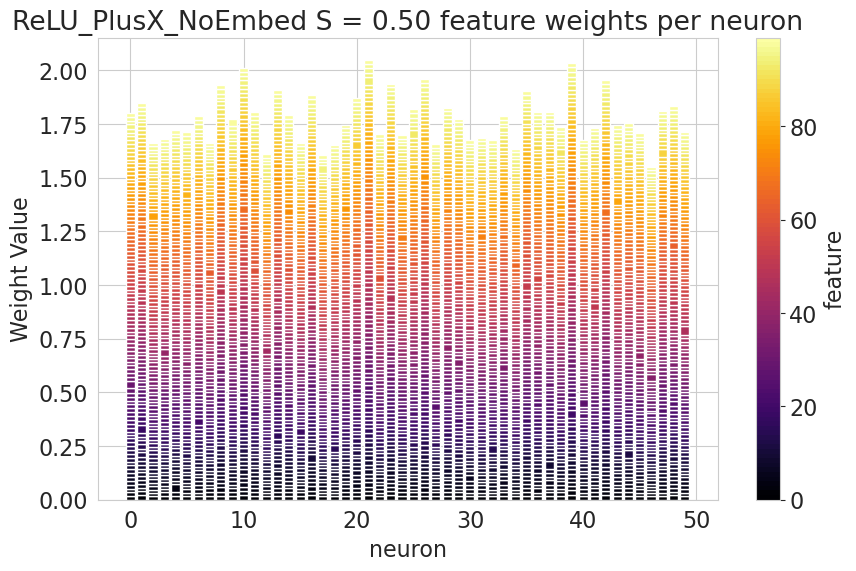

In [19]:
"""Plot weights for neurons per feature, and for features per neuron."""

W = einsum(
    reluPlusX_res_embed_cis.We,
    reluPlusX_res_embed_cis.W1,
    reluPlusX_res_embed_cis.W2,
    reluPlusX_res_embed_cis.Wu,
    "inst emb feat, inst neuron emb, inst emb neuron, inst feat emb -> neuron feat"
) * reluPlusX_res_embed_cfg.We_dim / reluPlusX_res_embed_cfg.n_feat
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature")
fig.get_axes()[0].set_title("ReLU_PlusX_Embed S = 0.50 neuron weights per feature")

fig = plot_weight_bars(W.T, xax="neuron")
fig.get_axes()[0].set_title("ReLU_PlusX_NoEmbed S = 0.50 feature weights per neuron")

In [20]:
"""Train model at low sparsity (S=0.99)"""

reluPlusX_res_embed_cis = Cis(reluPlusX_res_embed_cfg, device=device)

batch_sz = 2048
feat_sparsity = 0.99
feat_importance = 1
lr = 3e-3
n_steps = 10000
logging_freq = n_steps // 10


losses = train(
        reluPlusX_res_embed_cis,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        n_steps,
        lr, 
        logging_freq
)
display(losses)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.001908190199173987,
 0.0007082969532348216,
 0.000698241638019681,
 0.0007073523593135178,
 0.0007209150935523212,
 0.0007004566141404212,
 0.0006624373490922153,
 0.0006550838588736951,
 0.000671621470246464,
 0.0006952059338800609,
 0.0006462492165155709]

In [21]:
"""Get loss at inference over varying sparsity levels."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1
logging_freq = n_steps // 10

loss_data = []  # will store loss data

pbar = tqdm(sparsities, desc="Testing over sparsities")
n_examples = 10000
loss_data = []
for s in pbar:
    
    with t.no_grad():
        # generate examples of inputs
        x, y_true = gen_batch(reluPlusX_res_embed_cis, n_examples, s)
        
        # compute mean loss
        y = reluPlusX_res_embed_cis.forward(x)
        active_weight, inactive_weight = 10, 1
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        loss = weights * (y - y_true) ** 2
        
        # store loss at sparsity level
        loss = rearrange(loss, "examples 1 features -> examples features")
        loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
        for feat_idx, val in enumerate(loss):
            loss_data.append({"sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

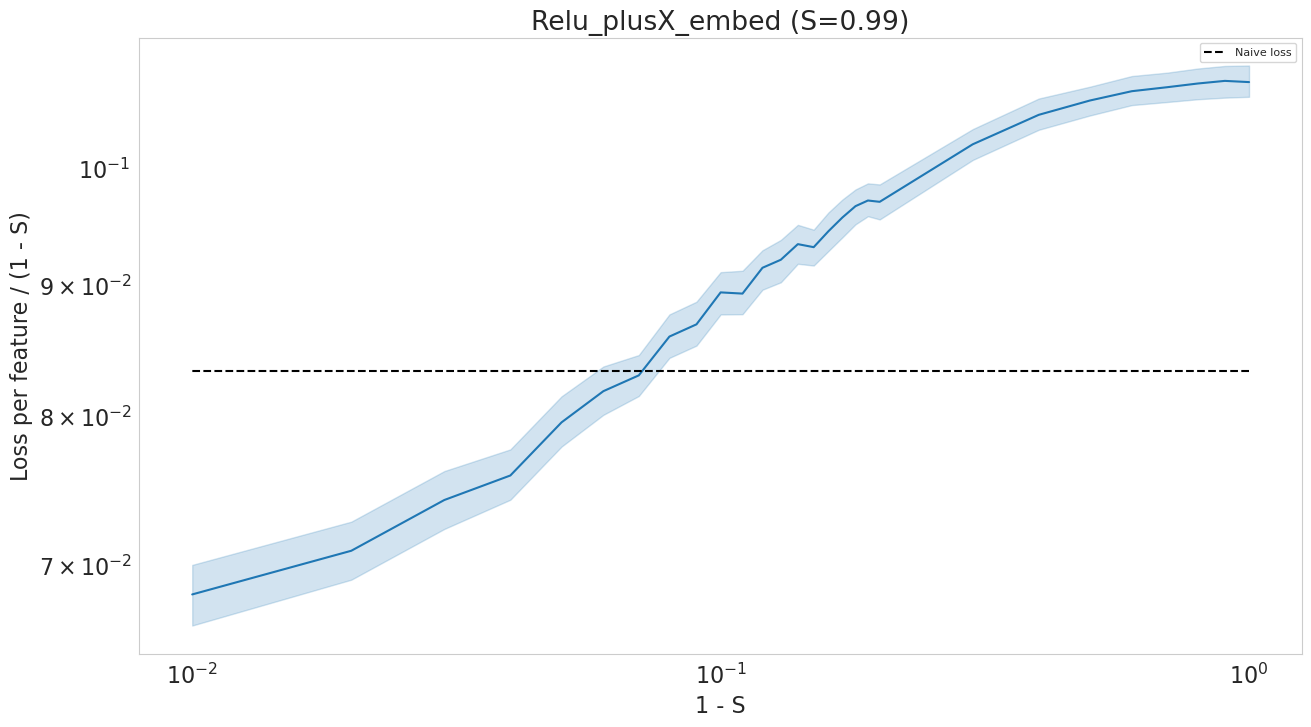

In [22]:
"""Plot performance across different input sparsities"""

# convert loss data to DataFrame, convert sparsity to probability and adjust loss
df_loss = pd.DataFrame(loss_data) 
df_loss["1-S"] = 1 - df_loss["sparsity"]
df_loss["loss/1-S"] = df_loss["loss_per_feature"] / (1 - df_loss["sparsity"])

naive_loss = 0.5 * (1 - sparsities) / 6 # compute naive loss (monosemantic solution)
norm_loss = naive_loss.ravel() / (1 - sparsities)

# plot performance vs input sparsity
fig = plt.figure(figsize=(15, 8))
sns.lineplot(data = df_loss, x = "1-S", y = "loss/1-S")

# add naive loss line
plt.plot(1- sparsities, norm_loss, linestyle="dashed", color="black", label=r"Naive loss") 

# add labels and scale
plt.xlabel('1 - S')
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend(loc = "best", fontsize = 8)
plt.ylabel('Loss per feature / (1 - S)')
plt.title('Relu_plusX_embed (S=0.99)')

# save figure and show
plt.savefig("/workspace/reluPlusX_Embed_S=099_performance.png", dpi=200)
plt.show()

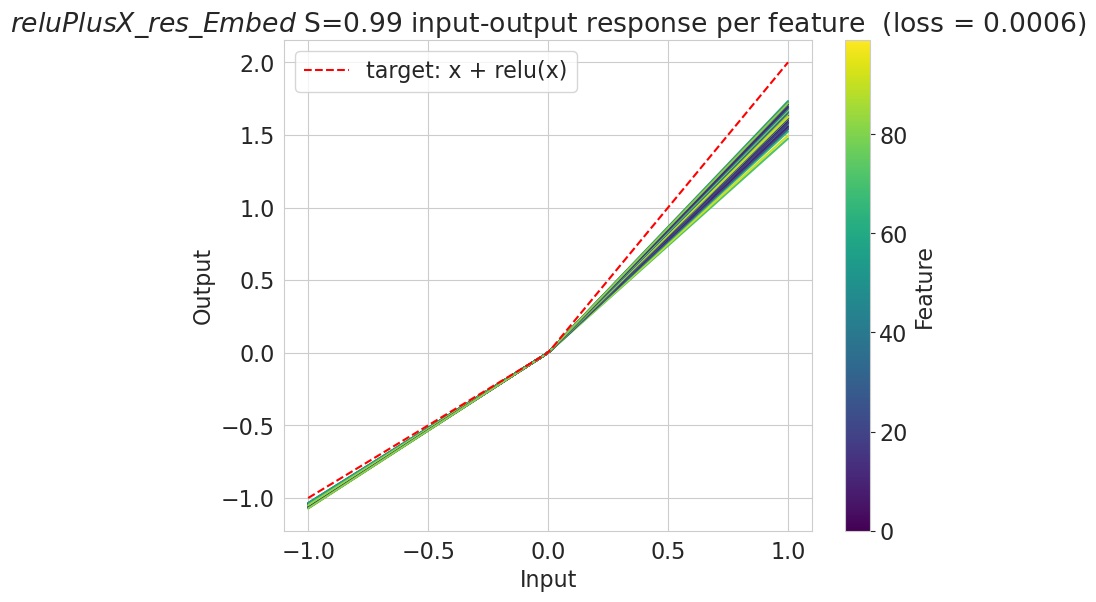

In [23]:
"""Plot feature representation (input-output response)"""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(reluPlusX_res_embed_cis, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(
    asnumpy(vals), asnumpy(vals + t.relu(vals)), color="red", linestyle="--", label="target: x + relu(x)"
)
ax.set_title(
    r"$\mathit{reluPlusX\_res\_Embed}$ S=0.99 " 
    + f"input-output response per feature  (loss = {losses[-1]:.4f})"
)
ax.legend()

In [ ]:
"""Plot weights for neurons per feature, and for features per neuron."""

W = einsum(
    reluPlusX_res_embed_cis.We,
    reluPlusX_res_embed_cis.W1,
    reluPlusX_res_embed_cis.W2,
    reluPlusX_res_embed_cis.Wu,
    "inst emb feat, inst neuron emb, inst emb neuron, inst feat emb -> neuron feat"
) * reluPlusX_res_embed_cfg.We_dim / reluPlusX_res_embed_cfg.n_feat
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W, xax="feature")
fig.get_axes()[0].set_title("ReLU_PlusX_Embed S = 0.99 neuron weights per feature")

fig = plot_weight_bars(W.T, xax="neuron")
fig.get_axes()[0].set_title("ReLU_PlusX_NoEmbed S = 0.99 feature weights per neuron")

W.shape=torch.Size([50, 100])
